# Requirement *(Autoencoders for Image Denoising and Super-Resolution)*
* Xây dựng các mô hình Autoencoders cho hai tác vụ Denoising và Image Super-Resolution (2x upscaling). Chạy thực nghiệm và demo kết quả trên tập dữ liệu CIFAR-10.
* Cần cho thấy kết quả huấn luyện mô hình, demo mô hình sau khi huấn luyên cho cả 2 tác vụ Denoising và Super-Resolution (2x upscaling).
* Kiến trúc Autoencoder có thể tham khảo trong tài liệu bài giảng tương ứng hoặc trong các nguồn khác. Kiến trúc Autoencoder cần được thay đổi cho phù hợp với mỗi dataset và tác vụ cụ thể.

## 1. Image Denoising <a class="anchor" id="image_denoising"></a>

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
(train_clean, _), (test_clean, _) = cifar10.load_data()
# scaling input data
train_clean = train_clean.astype('float32') / 255.
test_clean = test_clean.astype('float32') / 255.

def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

train_noisy = add_noise_and_clip_data(train_clean)
test_noisy = add_noise_and_clip_data(test_clean)

170498071/170498071 [==============================] - 4s 0us/step


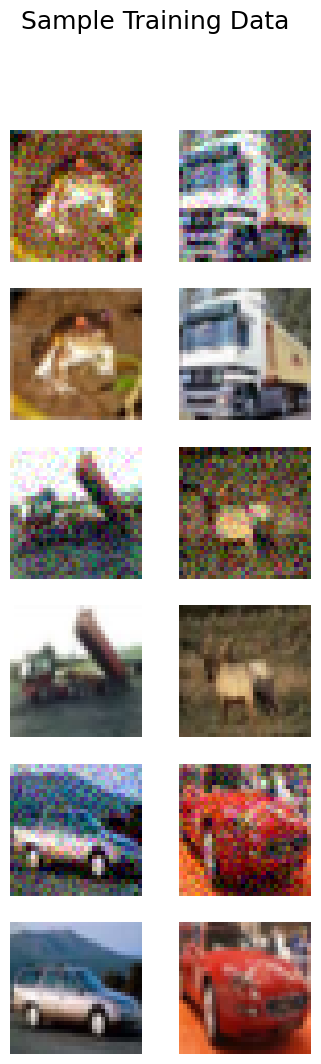

In [3]:
rows = 3 # defining no. of rows in figure
cols = 2 # defining no. of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # defining a figure

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_noisy[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i + 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_clean[i * cols + j])
        plt.axis("off")

f.suptitle("Sample Training Data", fontsize = 18)
#plt.savefig("Cifar-train.png")

plt.show()

In [4]:
def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

In [5]:
def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)

    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)

    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [6]:
denoising_model = autoencoder()

def scheduler(epoch):
    if epoch < 20:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (20 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('denoising_model.weights.h5', verbose = 1, save_best_only = True, save_weights_only = True)

denoising_model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
denoising_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['inputs[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['batch_normalizatio

In [7]:
# Training
denoising_training_history = denoising_model.fit(train_noisy,
                                                 train_clean,
                                                 validation_data = (test_noisy, test_clean),
                                                 epochs = 20,
                                                 batch_size = 128,
                                                 shuffle = True,
                                                 callbacks = [checkpoint, callbacks, lr])

Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.5419
Epoch 1: val_loss improved from inf to 0.10370, saving model to denoising_model.weights.h5
391/391 [==============================] - 37s 57ms/step - loss: 0.6183 - accuracy: 0.5419 - val_loss: 0.1037 - val_accuracy: 0.5631 - lr: 1.0000e-04
Epoch 2/20
390/391 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.6884
Epoch 2: val_loss improved from 0.10370 to 0.02020, saving model to denoising_model.weights.h5
391/391 [==============================] - 18s 46ms/step - loss: 0.0399 - accuracy: 0.6884 - val_loss: 0.0202 - val_accuracy: 0.7052 - lr: 1.0000e-04
Epoch 3/20
390/391 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.7391
Epoch 3: val_loss improved from 0.02020 to 0.01073, saving model to denoising_model.weights.h5
391/391 [==============================] - 19s 49ms/step - loss: 0.0124 - accuracy: 0.7391 - val_loss: 0.0107 - val_accuracy: 0.744

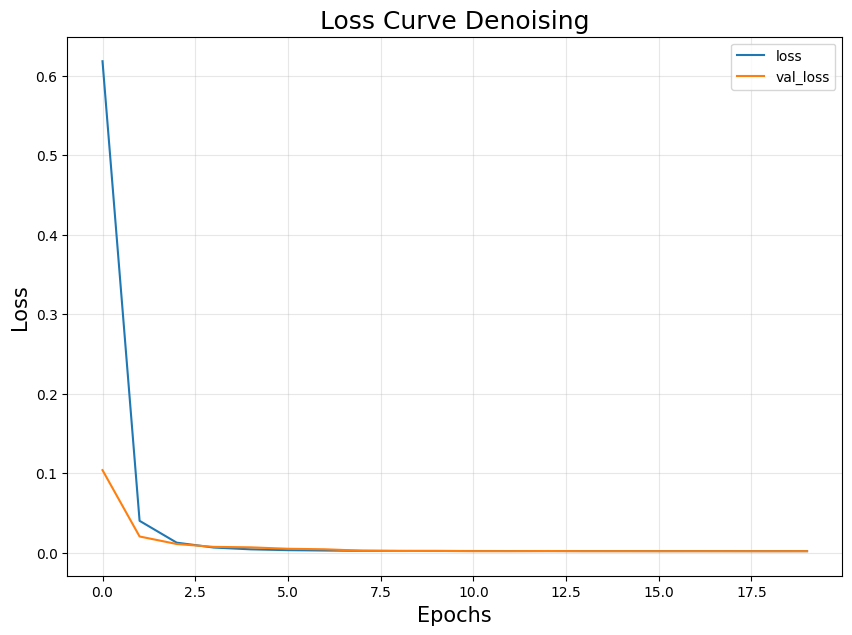

In [8]:
 # Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(denoising_training_history.epoch, denoising_training_history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(denoising_training_history.epoch, denoising_training_history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve Denoising",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
# plt.axis([0, 10, 0, 1])
plt.savefig("Loss_curve_denoising_cifar10.png")
plt.show()

In [9]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, test_noisy.shape[0]-48)

cifar_test_images = test_noisy[rand:rand+num_imgs] # slicing
cifar_test_predicted = denoising_model.predict(cifar_test_images) # predict

2/2 [==============================] - 1s 7ms/step


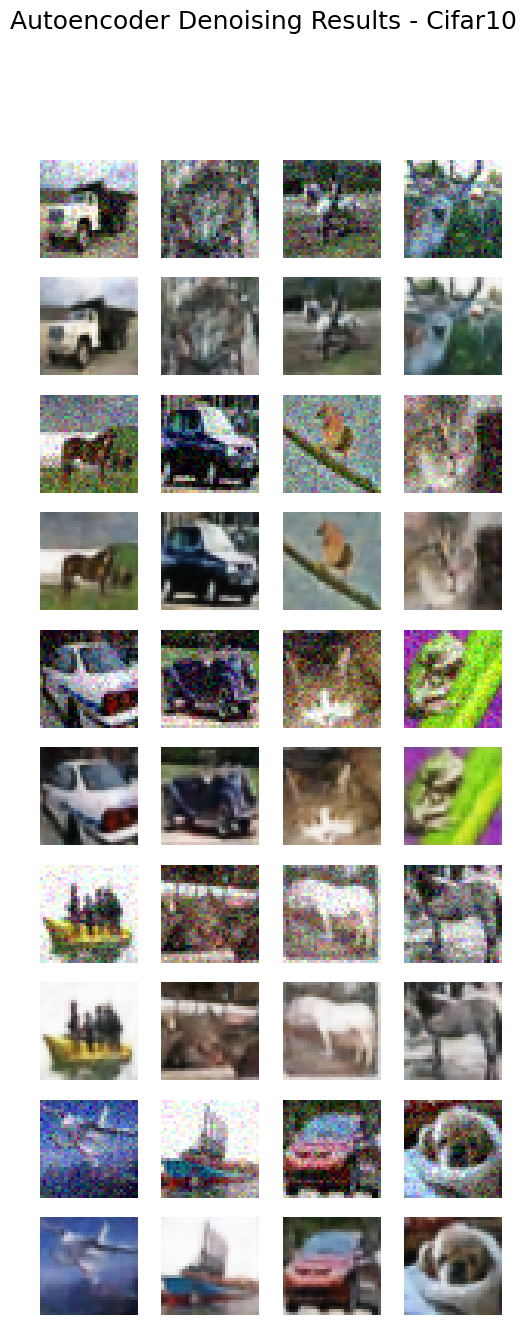

In [10]:
rows = 5 # defining no. of rows in figure
cols = 4 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j])
        plt.axis("off")

f.suptitle("Autoencoder Denoising Results - Cifar10",fontsize=18)
plt.savefig("denoising_test_results_cifar10.png")

plt.show()

## 2. Super-Resolution <a class="anchor" id="super-resolution"></a>

In [11]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(32,32) if z.size==32*32 else z.reshape(16,16) if z.size==16*16 else z)
    plt.show()

In [12]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse
from keras.layers import AveragePooling2D
from keras.datasets import cifar10
import numpy as np

In [13]:
# Load CIFAR-10 dataset
(x_train, y_trainclass), (x_test, y_testclass) = cifar10.load_data()

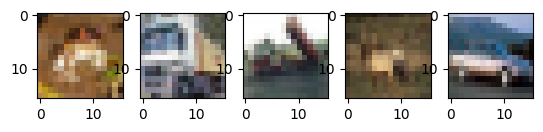

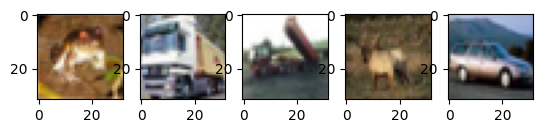

In [14]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_lr = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x_test).numpy()
plotn(5, x_train_lr)
plotn(5, x_train)

In [15]:
# Define input shape
inputs = Input(shape=(16, 16, 3), name='inputs')

# Encoder
conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv2)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv3)
conv4 = BatchNormalization()(conv4)

# Decoder
deconv1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv4)
deconv1 = BatchNormalization()(deconv1)
deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv1)
deconv2 = BatchNormalization()(deconv2)
deconv3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv2)
deconv3 = BatchNormalization()(deconv3)
deconv4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv3)
deconv4 = BatchNormalization()(deconv4)
# deconv5 = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(deconv4)
# deconv5 = BatchNormalization()(deconv5)

# Output
outputs = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(deconv4)

# Create model
autoencoder = Model(inputs, outputs, name='autoencoder')

In [16]:
super_resolution_model = autoencoder

def scheduler(epoch):
    if epoch < 20:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (20 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('super-resolution_model.weights.h5', verbose = 1, save_best_only = True, save_weights_only = True)

super_resolution_model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
super_resolution_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 16, 16, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_11 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_12 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         

In [17]:
# Training
super_resolution_training_history = super_resolution_model.fit(x_train_lr,
                                                               x_train,
                                                               validation_data = (x_test_lr, x_test),
                                                               epochs = 20,
                                                               batch_size = 128,
                                                               shuffle = True,
                                                               callbacks = [checkpoint, callbacks, lr])

Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.3884
Epoch 1: val_loss improved from inf to 0.02304, saving model to super-resolution_model.weights.h5
391/391 [==============================] - 15s 24ms/step - loss: 0.0282 - accuracy: 0.3884 - val_loss: 0.0230 - val_accuracy: 0.4644 - lr: 1.0000e-04
Epoch 2/20
389/391 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.5598
Epoch 2: val_loss improved from 0.02304 to 0.01131, saving model to super-resolution_model.weights.h5
391/391 [==============================] - 8s 20ms/step - loss: 0.0123 - accuracy: 0.5601 - val_loss: 0.0113 - val_accuracy: 0.5807 - lr: 1.0000e-04
Epoch 3/20
388/391 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.6144
Epoch 3: val_loss improved from 0.01131 to 0.00938, saving model to super-resolution_model.weights.h5
391/391 [==============================] - 8s 20ms/step - loss: 0.0094 - accuracy: 0.6145 - val_loss: 0.0094 - 

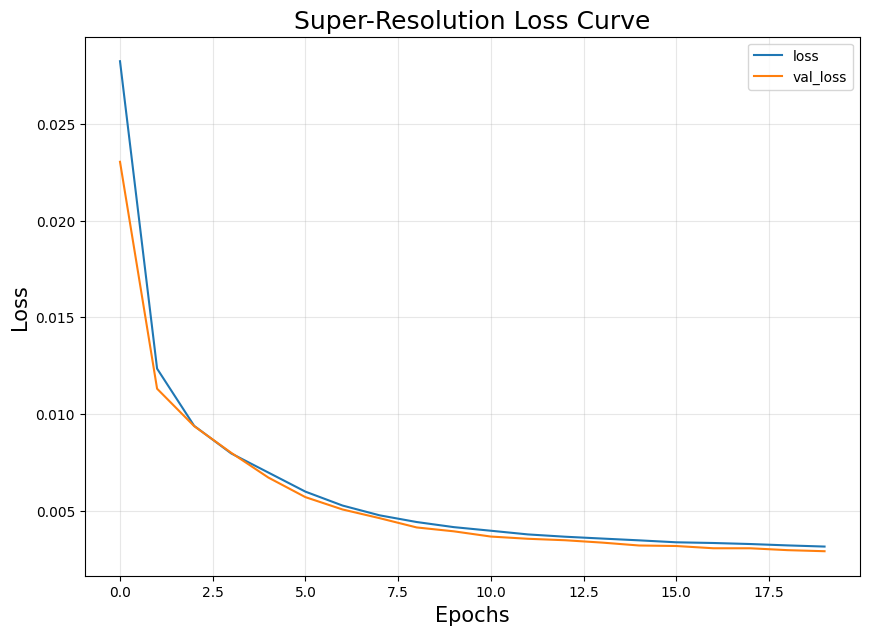

In [18]:
 # Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(super_resolution_training_history.epoch, super_resolution_training_history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(super_resolution_training_history.epoch, super_resolution_training_history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Super-Resolution Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_super-resolution_cifar10.png")
plt.show()

In [19]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, x_test_lr.shape[0]-48)

cifar_test_images = x_test_lr[rand:rand+num_imgs] # slicing
cifar_test_predicted = super_resolution_model.predict(cifar_test_images) # predict

2/2 [==============================] - 1s 6ms/step


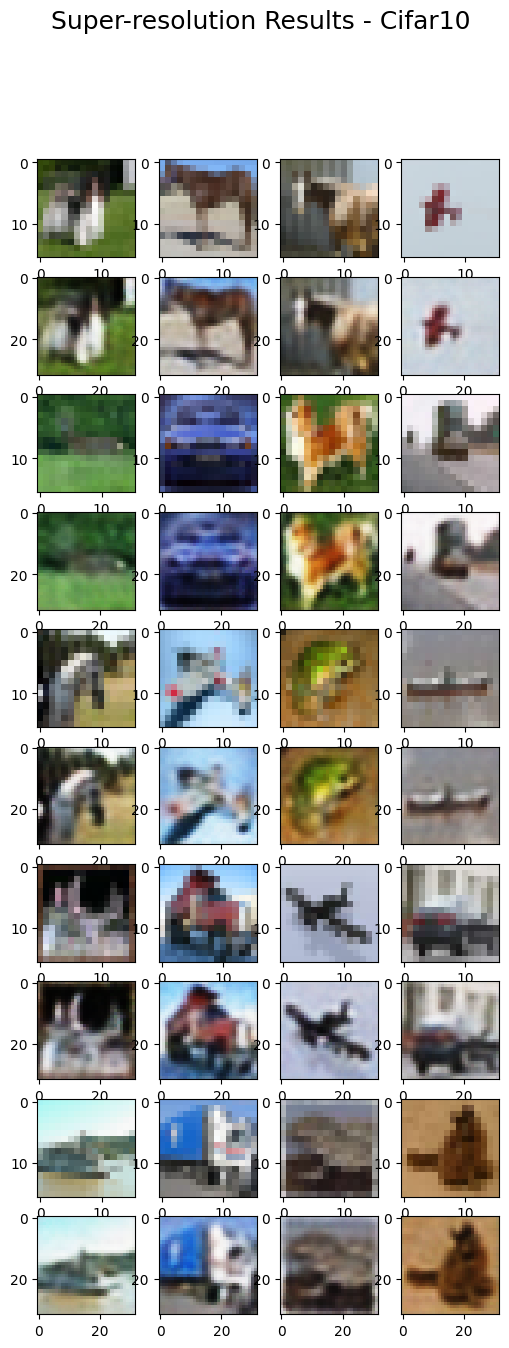

In [20]:
rows = 5 # defining no. of rows in figure
cols = 4 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j])
        plt.axis("on")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j])
        plt.axis("on")

f.suptitle("Super-resolution Results - Cifar10",fontsize=18)
plt.savefig("super-resolution_test_results_cifar10.png")

plt.show()